<a href="https://colab.research.google.com/github/ritish1082/Study-Buddy-AI/blob/main/Study_Buddy_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study Buddy AI

Craeting an AI chatbt using RAG models to take PDFs of lecture notes/slides (only text as of now) to help you study and clarify concepts by using it as a chatbot.

# 0. Dependencies

In [ ]:
# ! pip install langchain chromadb google-generativeai sentence-transformers pymupdf


In [ ]:
# ! pip install -U langchain-community

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os


In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY']= os.environ.get('LANGCHAIN_API_KEY')


# 1. Indexing

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import fitz

In [4]:
# Extract text from PDF using fitz (pymupdf)

def extract_text_from_pdf(pdf_path):
    text = ""
    doc = fitz.open(pdf_path)
    for page in doc:
        text += page.get_text("text") + "\n"
    return text


In [12]:
# # Load embeddings model (MiniLM)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [6]:
PDF_FILE_PATH = "test\Quantum_Assignment_1_2025.pdf"

In [10]:
from chromadb.utils import embedding_functions

embedding_model_miniLM_L6_v2 = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2"
)

In [9]:
# Load the text
pdf_text = extract_text_from_pdf(PDF_FILE_PATH)

# Split text into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
text_chunks = text_splitter.split_text(pdf_text)

In [13]:
vector_store = Chroma.from_texts(text_chunks, embedding=embedding_model, persist_directory="database/chroma_db", collection_name="quantum_rizz")


In [14]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})

In [15]:
# test
query = "electric field of electromagnetic waves"
retrieved_docs = retriever.get_relevant_documents(query)

for i, doc in enumerate(retrieved_docs):
    print(f"🔹 Result {i+1}: {doc.page_content}\n")

C:\Users\sriti\AppData\Local\Temp\ipykernel_2100\1440797334.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)
Number of requested results 20 is greater than number of elements in index 5, updating n_results = 5


🔹 Result 1: EECE-5653 Spring 2025: Assignment 1
Due: Jan. 16th
Problem 1: Phase of Travelling Waves (10 Points)
We write the electric field of electromagnetic waves as
E = E0 sin (k x −ω t + ϕ0)
and define the phase of the wave as ϕ = k x −ω t + ϕ0. For simplicity, we set t = 0 and ϕ0 = 0.
a. What is the phase ϕ of the wave at x = 0 ?
b. What is the phase ϕ of the wave at x = λ/4 ?
c. What is the phase ϕ of the wave at x = λ/2 ?
d. What is the phase ϕ of the wave at x = λ ?

🔹 Result 2: Problem 4: Fourier Transform of a Gaussian Pulse (15 Points)
a. Given a Gaussian pulse
ψ (t) =
1
π1/4∆T 1/2 exp

−
t2
2∆T 2

(4)
Find its Fourier transform ϕ (ω) using the above definition. Show that this is also a Gaussian.
b. We indicate the width of the Gaussian pulse 2∆T as
ψ (t = ±∆T) = ψ (t = 0) 1
e2
(5)
Find the width of ϕ (ω). Show that width of ϕ (ω) increases as the width ∆T of the Gaussian pulse decreases.
You can look it up online.
2

🔹 Result 3: a. What happens to Po2 if we change x2 by m

# 3. Retreival & Generation

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain import hub


In [17]:
# Initialize the LLM with your API key
llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=os.environ.get('GEMINI_API_KEY'))

In [18]:
# Define prompt for question-answering
# prompt = hub.pull("rlm/rag-prompt")

# Define the prompt template
template = """You are a friendly and supportive study buddy helping a student prepare for exams. Answer the question below using the provided context. **If the context is unclear or lacks details, use your own LLM knowledge to fill in the gaps.** 

Make sure your answer is inferred from the context, even if the exact words aren't present. Keep it **engaging, easy to understand, and conversational—just like a real study session.** 

---

**Context:**  
{context}  

**Question:**  
{question}  

Now, explain it as if you're helping a friend—clear, to the point, and friendly!
"""


prompt = ChatPromptTemplate.from_template(template)


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(f"Document {i+1}: {doc.page_content}" for i, doc in enumerate(state["context"]))
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()




In [27]:
response = graph.invoke({"question": "What is the equation of electic magnetic wave here?"})
print("Question:", response["question"])
print("Context:", response["context"])
print("Answer:", response["answer"])

Question: What is the equation of electic magnetic wave here?
Context: [Document(metadata={}, page_content='EECE-5653 Spring 2025: Assignment 1\nDue: Jan. 16th\nProblem 1: Phase of Travelling Waves (10 Points)\nWe write the electric field of electromagnetic waves as\nE = E0 sin (k x −ω t + ϕ0)\nand define the phase of the wave as ϕ = k x −ω t + ϕ0. For simplicity, we set t = 0 and ϕ0 = 0.\na. What is the phase ϕ of the wave at x = 0 ?\nb. What is the phase ϕ of the wave at x = λ/4 ?\nc. What is the phase ϕ of the wave at x = λ/2 ?\nd. What is the phase ϕ of the wave at x = λ ?'), Document(metadata={}, page_content='c. What is the phase ϕ of the wave at x = λ/2 ?\nd. What is the phase ϕ of the wave at x = λ ?\ne. What is the phase difference between two points x1 and x2 such that x2 = x1 + λ/4 ?\nProblem 2: Interferometer (10 Points)\nA Mach-Zehnder interferometer is set such that λ = 1 µm, x1 = 50 cm, x2 = 100 cm, and x1 is fixed. In this\ninitial state, the power in one of the detecto

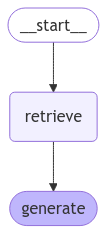

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))